In [19]:
!cp -r ../input/recsys-repo/RecSys_Course_AT_PoliMi-master/* ./

In [20]:

%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as pyplot
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [21]:
URM_path = "../input/urm-updated/URM_updated.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                header=0)
URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [22]:
URM_all_dataframe.head()

,UserID,ItemID,Interaction
0,0,21,1.0
1,0,124,1.0
2,0,808,1.0
3,0,1326,1.0
4,0,1995,1.0


In [23]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 24507, Number of users	 41629
Max ID items	 24506, Max Id users	 41628

Average interactions per user 25.27
Average interactions per item 42.92

Sparsity 99.90 %


In [24]:
URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))
URM_all = URM_all.tocsr() # to obtain fast access to rows (users)
URM_all

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1051828 stored elements in Compressed Sparse Row format>

In [25]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

# split data into train and validation data 80/20
URM_train, URM_valid = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_valid

(<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 841462 stored elements in Compressed Sparse Row format>,
 <41629x24507 sparse matrix of type '<class 'numpy.float64'>'
 	with 210366 stored elements in Compressed Sparse Row format>)

In [26]:
#Prepare ICM matrices for content based algos

ICM_type_df = pd.read_csv("../input/competition-data/data_ICM_type.csv")
ICM_type_df

,item_id,feature_id,data
0,0,1,1
1,1,3,1
2,2,4,1
3,3,1,1
4,4,3,1
...,...,...,...
23086,27963,1,1
23087,27964,2,1
23088,27965,1,1
23089,27966,1,1


In [30]:
items = ICM_type_df.item_id
features = ICM_type_df.feature_id
data = ICM_type_df.data
ICM_type = sps.coo_matrix((data, (items, features)))
ICM_type = ICM_type.tocsr() #fast row (items) access
ICM_type.shape

(27968, 8)

In [32]:
ICM_length_df = pd.read_csv("../input/competition-data/data_ICM_length.csv")
ICM_length_df

,item_id,feature_id,data
0,0,0,1
1,1,0,1
2,2,0,21
3,3,0,1
4,4,0,1
...,...,...,...
23086,27963,0,1
23087,27964,0,1
23088,27965,0,1
23089,27966,0,1


In [35]:
items = ICM_length_df.item_id
features = ICM_length_df.feature_id
data = ICM_length_df.data
ICM_length = sps.coo_matrix((data, (items, features)))
ICM_length = ICM_length.tocsr() #fast row (items) access
ICM_length.shape

(27968, 1)

In [37]:
# Concatenation of two ICM matrices
ICM_combined = sps.hstack((ICM_type, ICM_length))
ICM_combined.shape

(27968, 9)

In [38]:
from Evaluation.Evaluator import EvaluatorHoldout

#create an evaluator object to evaluate validation set
#we will use it for hyperparameter tuning
evaluator_valid = EvaluatorHoldout(URM_valid, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1593 ( 3.8%) Users that have less than 1 test interactions


In [39]:
import numpy as np 
import scipy.sparse as sps

# count how many interactions each user has
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([ 8, 10, 44, ..., 10, 41, 11], dtype=int32), (41629,))

In [40]:
# select 5% of users with least interactions
block_size = int(len(profile_length)*0.05)
block_size

2081

In [41]:
sorted_users = np.argsort(profile_length)
sorted_users

array([34942, 35690, 31656, ..., 12667,  9097, 38102])

In [42]:
# do the same for all users to obtain a division in 20 different groups of users
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 5.14, median 5.0, min 0, max 6
Group 1, #users in group 2081, average p.len 7.25, median 7.0, min 6, max 8
Group 2, #users in group 2081, average p.len 8.36, median 8.0, min 8, max 9
Group 3, #users in group 2081, average p.len 9.31, median 9.0, min 9, max 10
Group 4, #users in group 2081, average p.len 10.14, median 10.0, min 10, max 11
Group 5, #users in group 2081, average p.len 11.00, median 11.0, min 11, max 11
Group 6, #users in group 2081, average p.len 11.98, median 12.0, min 11, max 12
Group 7, #users in group 2081, average p.len 12.85, median 13.0, min 12, max 13
Group 8, #users in group 2081, average p.len 13.78, median 14.0, min 13, max 14
Group 9, #users in group 2081, average p.len 14.74, median 15.0, min 14, max 15
Group 10, #users in group 2081, average p.len 15.85, median 16.0, min 15, max 17
Group 11, #users in group 2081, average p.len 17.28, median 17.0, min 17, max 18
Group 12, #users in group 2081, average p.len 18.64, 

In [43]:
import numpy as np
import scipy.sparse as sps
from Recommenders.Recommender_utils import check_matrix
from sklearn.linear_model import ElasticNet
from Recommenders.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
import time, sys
from tqdm import tqdm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# os.environ["PYTHONWARNINGS"] = ('ignore::exceptions.ConvergenceWarning:sklearn.linear_model')
# os.environ["PYTHONWARNINGS"] = ('ignore:Objective did not converge:ConvergenceWarning:')

class SLIMElasticNetRecommender(BaseItemSimilarityMatrixRecommender):
    """
    Train a Sparse Linear Methods (SLIM) item similarity model.
    NOTE: ElasticNet solver is parallel, a single intance of SLIM_ElasticNet will
          make use of half the cores available
    See:
        Efficient Top-N Recommendation by Linear Regression,
        M. Levy and K. Jack, LSRS workshop at RecSys 2013.
        SLIM: Sparse linear methods for top-n recommender systems,
        X. Ning and G. Karypis, ICDM 2011.
        http://glaros.dtc.umn.edu/gkhome/fetch/papers/SLIM2011icdm.pdf
    """

    RECOMMENDER_NAME = "SLIMElasticNetRecommender"

    def __init__(self, URM_train, verbose = True):
        super(SLIMElasticNetRecommender, self).__init__(URM_train, verbose = verbose)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, l1_ratio=0.1, alpha = 1.0, positive_only=True, topK = 100,**earlystopping_kwargs):

        assert l1_ratio>= 0 and l1_ratio<=1, "{}: l1_ratio must be between 0 and 1, provided value was {}".format(self.RECOMMENDER_NAME, l1_ratio)

        self.l1_ratio = l1_ratio
        self.positive_only = positive_only
        self.topK = topK


        # initialize the ElasticNet model
        self.model = ElasticNet(alpha=alpha,
                                l1_ratio=self.l1_ratio,
                                positive=self.positive_only,
                                fit_intercept=False,
                                copy_X=False,
                                precompute=True,
                                selection='random',
                                max_iter=100,
                                tol=1e-4)

        URM_train = check_matrix(self.URM_train, 'csc', dtype=np.float32)

        n_items = URM_train.shape[1]

        # Use array as it reduces memory requirements compared to lists
        dataBlock = 10000000

        rows = np.zeros(dataBlock, dtype=np.int32)
        cols = np.zeros(dataBlock, dtype=np.int32)
        values = np.zeros(dataBlock, dtype=np.float32)

        numCells = 0

        start_time = time.time()
        start_time_printBatch = start_time

        # fit each item's factors sequentially (not in parallel)
        for currentItem in range(n_items):

            # get the target column
            y = URM_train[:, currentItem].toarray()

            # set the j-th column of X to zero
            start_pos = URM_train.indptr[currentItem]
            end_pos = URM_train.indptr[currentItem + 1]

            current_item_data_backup = URM_train.data[start_pos: end_pos].copy()
            URM_train.data[start_pos: end_pos] = 0.0

            # fit one ElasticNet model per column
            self.model.fit(URM_train, y)

            # self.model.coef_ contains the coefficient of the ElasticNet model
            # let's keep only the non-zero values

            # Select topK values
            # Sorting is done in three steps. Faster then plain np.argsort for higher number of items
            # - Partition the data to extract the set of relevant items
            # - Sort only the relevant items
            # - Get the original item index

            nonzero_model_coef_index = self.model.sparse_coef_.indices
            nonzero_model_coef_value = self.model.sparse_coef_.data

            local_topK = min(len(nonzero_model_coef_value)-1, self.topK)

            relevant_items_partition = (-nonzero_model_coef_value).argpartition(local_topK)[0:local_topK]
            relevant_items_partition_sorting = np.argsort(-nonzero_model_coef_value[relevant_items_partition])
            ranking = relevant_items_partition[relevant_items_partition_sorting]

            for index in range(len(ranking)):

                if numCells == len(rows):
                    rows = np.concatenate((rows, np.zeros(dataBlock, dtype=np.int32)))
                    cols = np.concatenate((cols, np.zeros(dataBlock, dtype=np.int32)))
                    values = np.concatenate((values, np.zeros(dataBlock, dtype=np.float32)))


                rows[numCells] = nonzero_model_coef_index[ranking[index]]
                cols[numCells] = currentItem
                values[numCells] = nonzero_model_coef_value[ranking[index]]

                numCells += 1

            # finally, replace the original values of the j-th column
            URM_train.data[start_pos:end_pos] = current_item_data_backup

            elapsed_time = time.time() - start_time
            new_time_value, new_time_unit = seconds_to_biggest_unit(elapsed_time)


            if time.time() - start_time_printBatch > 300 or currentItem == n_items-1:
                self._print("Processed {} ({:4.1f}%) in {:.2f} {}. Items per second: {:.2f}".format(
                    currentItem+1,
                    100.0* float(currentItem+1)/n_items,
                    new_time_value,
                    new_time_unit,
                    float(currentItem)/elapsed_time))

                sys.stdout.flush()
                sys.stderr.flush()

                start_time_printBatch = time.time()

        # generate the sparse weight matrix
        self.W_sparse = sps.csr_matrix((values[:numCells], (rows[:numCells], cols[:numCells])),
                                       shape=(n_items, n_items), dtype=np.float32)

In [48]:
import os

output_folder_path = "result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

In [49]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7f65753b3610>)

In [50]:
#prepare the environment to run Cython code
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:746:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In function ‘__

In [52]:
#here we will save MAPs of different user groups
MAP_recommender_per_group = {}

#here we will save pairs label : recommnder_object
recommender_object_dict = {}
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

mf_ials = IALSRecommender(URM_train)
mf_ials.fit(num_factors = 31, confidence_scaling= 'log',alpha = 0.0024941846820976015, epsilon = 3.449297756742473, reg = 5.61162089901928e-05, epochs = 40)
recommender_object_dict["MF_IALS"] = mf_ials

IALSRecommender: URM Detected 1 ( 0.0%) users with no interactions.
IALSRecommender: Epoch 1 of 40. Elapsed time 12.83 sec
IALSRecommender: Epoch 2 of 40. Elapsed time 27.05 sec
IALSRecommender: Epoch 3 of 40. Elapsed time 39.38 sec
IALSRecommender: Epoch 4 of 40. Elapsed time 51.71 sec
IALSRecommender: Epoch 5 of 40. Elapsed time 1.10 min
IALSRecommender: Epoch 6 of 40. Elapsed time 1.32 min
IALSRecommender: Epoch 7 of 40. Elapsed time 1.56 min
IALSRecommender: Epoch 8 of 40. Elapsed time 1.77 min
IALSRecommender: Epoch 9 of 40. Elapsed time 2.01 min
IALSRecommender: Epoch 10 of 40. Elapsed time 2.23 min
IALSRecommender: Epoch 11 of 40. Elapsed time 2.45 min
IALSRecommender: Epoch 12 of 40. Elapsed time 2.69 min
IALSRecommender: Epoch 13 of 40. Elapsed time 2.93 min
IALSRecommender: Epoch 14 of 40. Elapsed time 3.17 min
IALSRecommender: Epoch 15 of 40. Elapsed time 3.40 min
IALSRecommender: Epoch 16 of 40. Elapsed time 3.65 min
IALSRecommender: Epoch 17 of 40. Elapsed time 3.88 min
IA

In [53]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=40)
recommender_object_dict["PURE_SVD"] = pure_svd

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 2.34 sec


In [54]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

itemknn_cf = ItemKNNCFRecommender(URM_train)
itemknn_cf.fit(topK = 157, shrink = 463, similarity = 'cosine', normalize = True, feature_weighting = 'TF-IDF')
recommender_object_dict["ItemKNNCF"] = itemknn_cf

ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
Similarity column 24507 (100.0%), 4667.66 column/sec. Elapsed time 5.25 sec


In [55]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

itemknn_cbf = ItemKNNCBFRecommender(URM_train, ICM_combined)
itemknn_cbf.fit(topK = 41, shrink = 1000, similarity = 'cosine', normalize = True, feature_weighting = 'TF-IDF')
recommender_object_dict["ItemKNNCBF"] = itemknn_cbf

ItemKNNCBFRecommender: URM Detected 1 ( 0.0%) users with no interactions.


AssertionError: ItemKNNCBFRecommender: URM_train has 24507 items but ICM_train has 27968

In [56]:
slim_en = SLIMElasticNetRecommender(URM_train)
slim_en.fit(epochs = 500, l1_ratio = 0.0023170159712850467, alpha = 0.09078974149197175, positive_only = True, topK = 363)
recommender_object_dict["SLIM_EN"] = slim_en

SLIMElasticNetRecommender: URM Detected 1 ( 0.0%) users with no interactions.
SLIMElasticNetRecommender: Processed 15465 (63.1%) in 5.00 min. Items per second: 51.54
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 7.31 min. Items per second: 55.90


In [58]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython_Epoch import MatrixFactorization_Cython_Epoch
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

slim_bpr = SLIM_BPR_Cython(URM_train)
slim_bpr.fit(epochs=650, sgd_mode = "sgd", topK = 483, lambda_i = 0.0006712905081189398, lambda_j = 0.06584150350451998, learning_rate = 0.0036482363905043207)
recommender_object_dict["SLIM_BPR"] = slim_bpr

SLIM_BPR_Recommender: URM Detected 1 ( 0.0%) users with no interactions.
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Available RAM is 27812.00 MB (86.61%) of 32110.00 MB, required is 2402.37 MB. Using dense matrix.
Processed 41629 (100.0%) in 0.64 sec. BPR loss is 2.47E-03. Sample per second: 65128
SLIM_BPR_Recommender: Epoch 1 of 650. Elapsed time 0.15 sec
Processed 41629 (100.0%) in 0.79 sec. BPR loss is 1.37E-02. Sample per second: 52736
SLIM_BPR_Recommender: Epoch 2 of 650. Elapsed time 0.30 sec
Processed 41629 (100.0%) in 0.93 sec. BPR loss is 3.43E-02. Sample per second: 44513
SLIM_BPR_Recommender: Epoch 3 of 650. Elapsed time 0.44 sec
Processed 41629 (100.0%) in 1.09 sec. BPR loss is 5.69E-02. Sample per second: 38277
SLIM_BPR_Recommender: Epoch 4 of 650. Elapsed time 0.60 sec
Processed 41629 (100.0%) in 0.23 sec. BPR loss is 8.50E-02. Sample per second: 177193
SLIM_BPR_Recommender: Epoch 5 of 650. Elapsed time 0.74 sec
Processed 41629 (100.0%) in 0.38 sec. 

In [59]:
from Recommenders.NonPersonalizedRecommender import TopPop

top_pop = TopPop(URM_train)
top_pop.fit()
recommender_object_dict["TOP_POP"] = top_pop

TopPopRecommender: URM Detected 1 ( 0.0%) users with no interactions.


In [60]:
# here we perform validation over different user groups for each model
# then we plot a graph to compare them
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_validation.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 2081, average p.len 5.14, median 5.0, min 0, max 6
EvaluatorHoldout: Ignoring 1593 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1905 (100.0%) in 2.74 sec. Users per second: 696
EvaluatorHoldout: Processed 1905 (100.0%) in 2.59 sec. Users per second: 735
EvaluatorHoldout: Processed 1905 (100.0%) in 2.13 sec. Users per second: 893
EvaluatorHoldout: Processed 1905 (100.0%) in 2.03 sec. Users per second: 937
EvaluatorHoldout: Processed 1905 (100.0%) in 2.20 sec. Users per second: 864
EvaluatorHoldout: Processed 1905 (100.0%) in 2.58 sec. Users per second: 739
Group 1, #users in group 2081, average p.len 7.25, median 7.0, min 6, max 8
EvaluatorHoldout: Ignoring 1593 ( 3.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1881 (100.0%) in 2.69 sec. Users per second: 699
EvaluatorHoldout: Processed 1881 (100.0%) in 2.54 sec. User

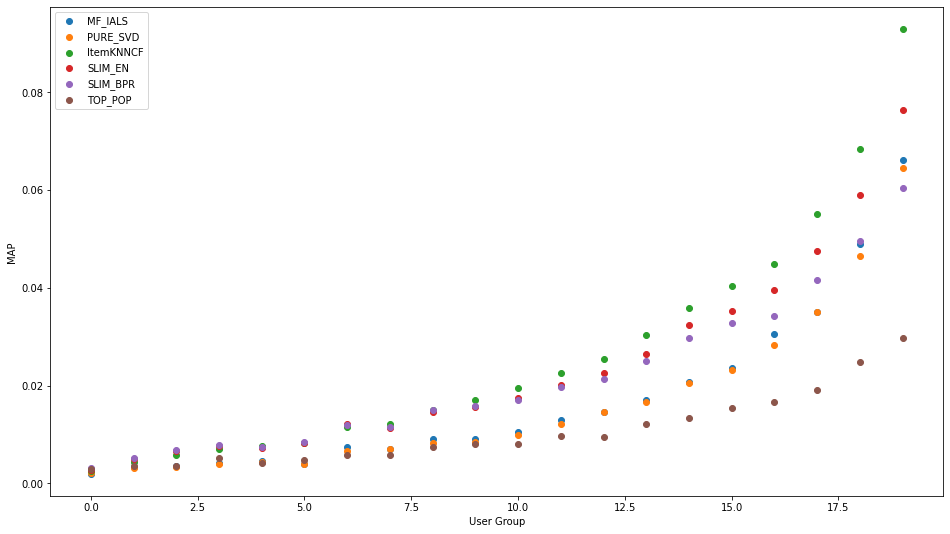

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()